In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV

In [ ]:
url = "https://raw.githubusercontent.com/ageron/data/main/housing/housing.csv"
data = pd.read_csv(url)

In [ ]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in this dataset. We notice that *total_bedrooms* attribute has only 20.433 non-null values, meaning that 207 districts are missing this feature. We will need to take care of this.
All attributes are numerical, except for *ocean_proximity* which is of type object. We also notice that *ocean_proximity* has repetitive values, indicating this must be a categorical attribute. We will find out what categories exist and how many districts belong to each category.

In [ ]:
data["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


We notice that five caegories exist in *ocean_proximity*.

In [ ]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

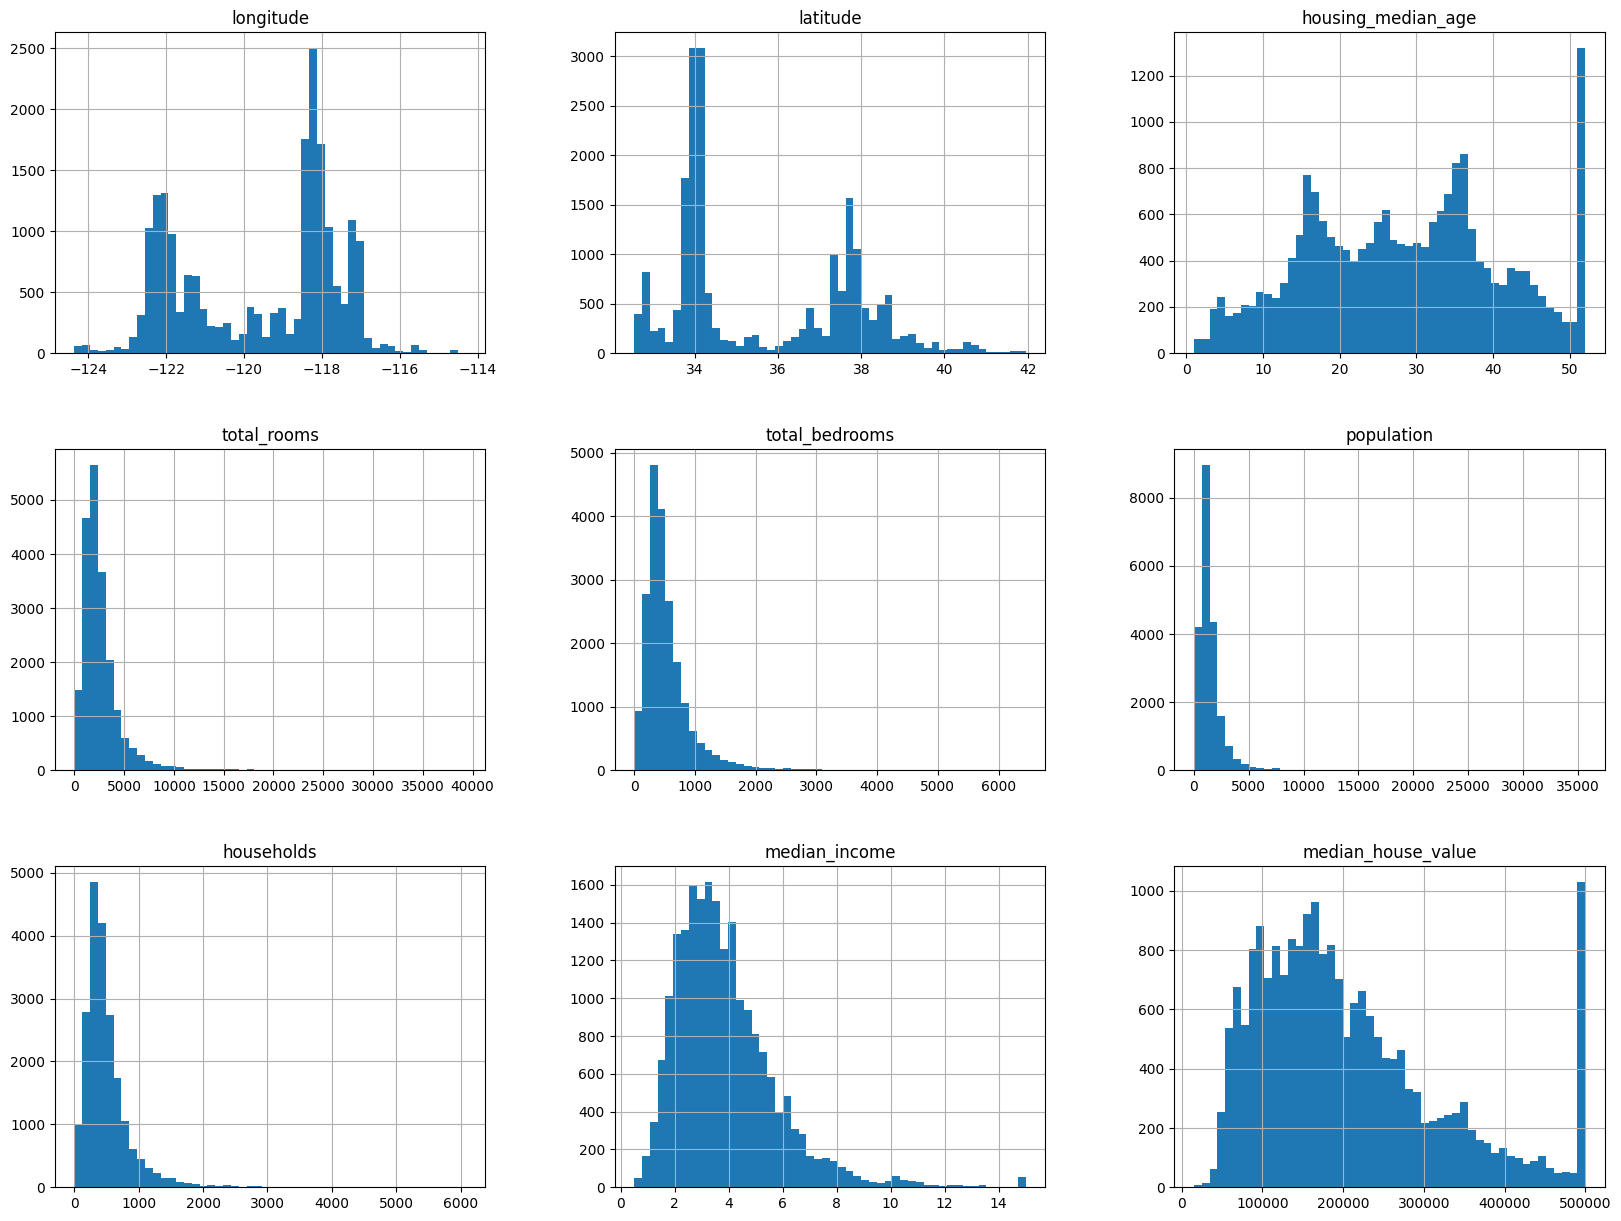

In [ ]:
data.hist(bins=50, figsize=(20,15))

We observe that several attributes are on very different scales, so feature scaling will be necessary.
We also notice that some of the features are skewed, thus transformation will be required.

In [ ]:
data_num = data.select_dtypes(include=['number'])
corr_matrix = data_num.corr()['median_house_value']
top_features = corr_matrix[abs(corr_matrix) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with Median House Value:\n{}".format(len(top_features), top_features))

There is 2 strongly correlated values with Median House Value:
median_house_value    1.000000
median_income         0.688075
Name: median_house_value, dtype: float64


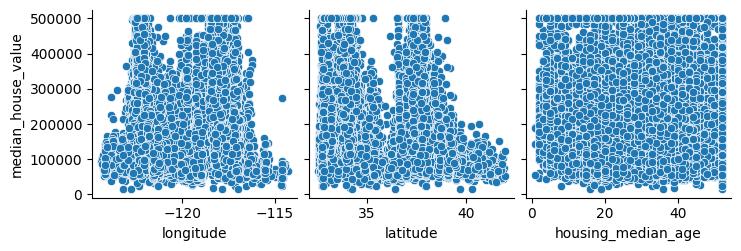

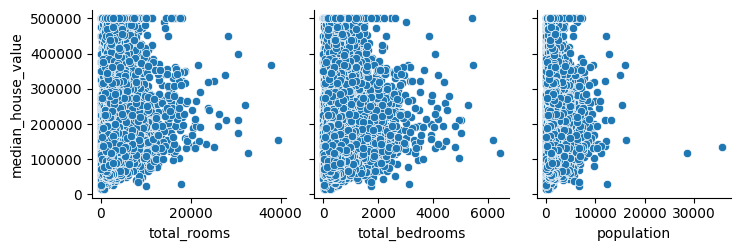

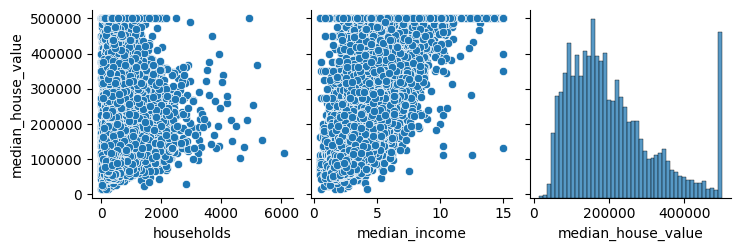

In [ ]:
for i in range(0, len(data_num.columns), 3):
    sns.pairplot(data=data_num,
                x_vars=data_num.columns[i:i+3],
                y_vars=['median_house_value'])

<Axes: >

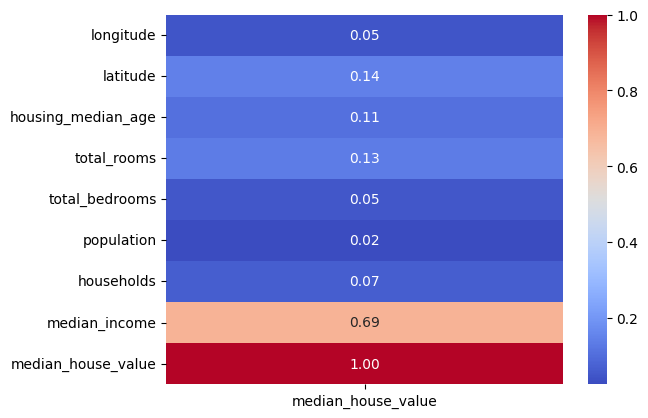

In [ ]:
corr_df = abs(corr_matrix).to_frame()
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm")

We observe that *median_income* has a somewhat strong correlation with the target. From above plot, we can see that the histogram for median_income is skewed, we also observe the linear relationship between *median_income* and *median_house_value*

/tmp/ipython-input-249763774.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  median_income_untransformed = sns.distplot(data['median_income'])


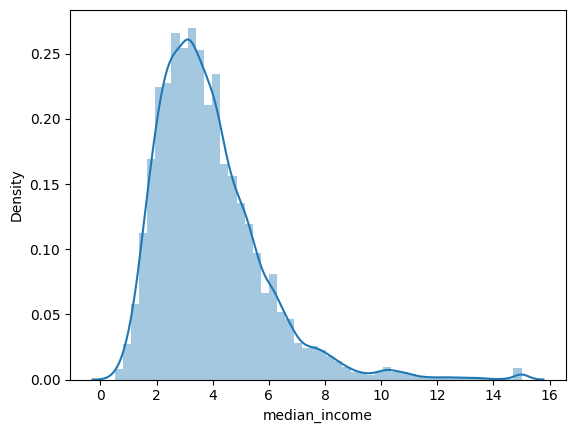

In [ ]:
median_income_untransformed = sns.distplot(data['median_income'])

As the plot shows, median_income deviates from a normal distribution. It has a long right tail, indicating a positive skew. To ensure that the test set is representative of the different income levels, we create a new attribute called income category, which groups incomes into strata with sufficient numbers of instances.

<Axes: xlabel='income_cat'>

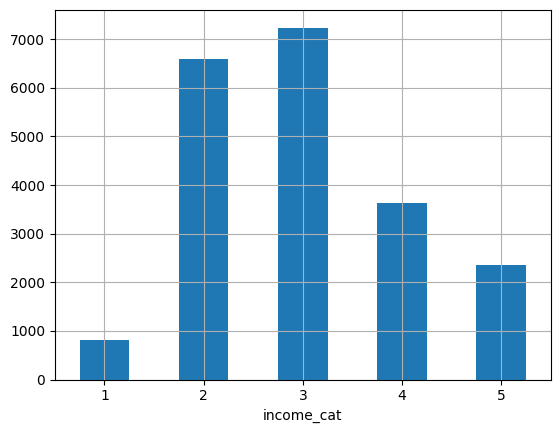

In [ ]:
data['income_cat'] = pd.cut(data['median_income'], bins=[0., 1.5, 3.0, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])
data['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)

In [ ]:
strat_train_set, strat_test_set = train_test_split(data, test_size=0.2, random_state=42, stratify=data['income_cat'])

In [ ]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


<Axes: xlabel='longitude', ylabel='latitude'>

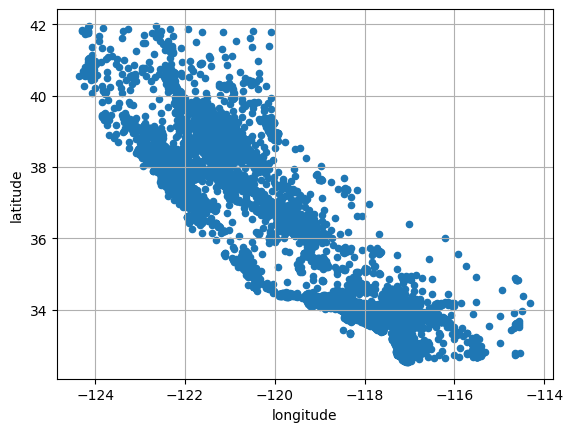

In [ ]:
data.plot(kind='scatter', x='longitude', y='latitude', grid=True)

Let's visulaize the points of high density

<Axes: xlabel='longitude', ylabel='latitude'>

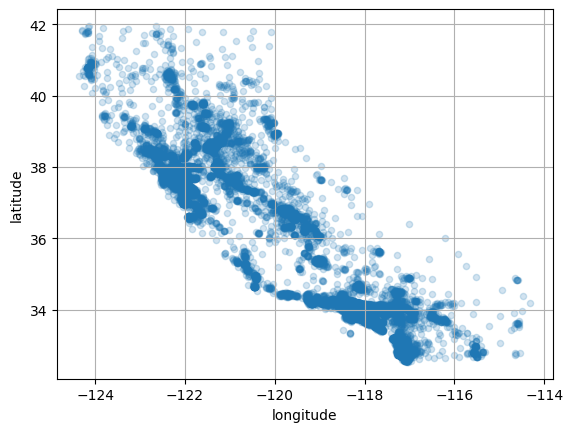

In [ ]:
data.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.2)

<Axes: xlabel='longitude', ylabel='latitude'>

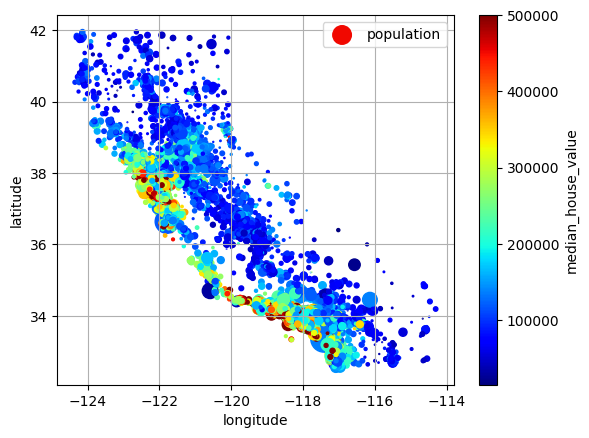

In [ ]:
data.plot(kind='scatter', x='longitude', y='latitude', grid=True, s=data['population']/100, label='population', c='median_house_value', cmap='jet', colorbar=True)

radius of each circle represents districts polulation, the color represents the price. From the plot, we observe that price tend to increase towards bottom-left(near the ocean, since this is California) of the plot. The *ocean_proximity* attribute could be useful here.

Let's reconsider the feature (median_income) that has most correlation.

<Axes: xlabel='median_income', ylabel='median_house_value'>

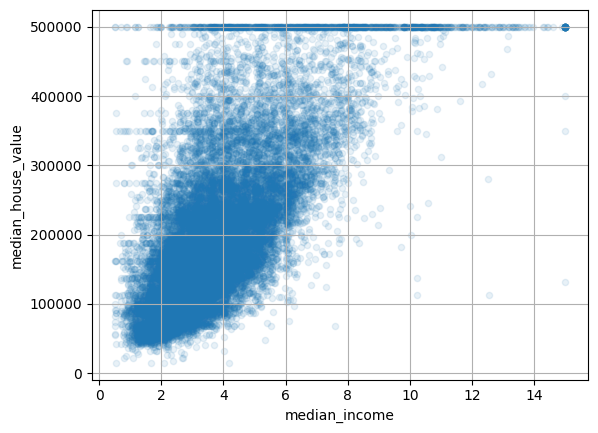

In [ ]:
data.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, grid=True)

In [ ]:
data.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat'],
      dtype='object')

The attribute total_rooms is not very useful if we dont know the how many households, also total number of bedrooms is not very useful, we may wanna now the number of bedrooms compared to total number of rooms. We can also consider the people per house.

In [ ]:
data['rooms_per_house'] = data['total_rooms'] / data['households']
data['bedrooms_ratio'] = data['total_bedrooms'] / data['total_rooms']
data['people_per_house'] = data['population'] / data['households']

Let's check the correlation again

In [ ]:
data_num = data.select_dtypes(include=['number'])
corr_matrix = data_num.corr()['median_house_value']
print(corr_matrix)

longitude            -0.045967
latitude             -0.144160
housing_median_age    0.105623
total_rooms           0.134153
total_bedrooms        0.049686
population           -0.024650
households            0.065843
median_income         0.688075
median_house_value    1.000000
rooms_per_house       0.151948
bedrooms_ratio       -0.255880
people_per_house     -0.023737
Name: median_house_value, dtype: float64


The *bedrooms_ratio* attribute shows negative correlation with the price, which means that the houses with lower bedrooms tend to be more expensive.

In [ ]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

Clean the data

We noticed earlier that the total_bedrooms attribute has some missing values, lets take care of that

In [ ]:
imputer = SimpleImputer(strategy='median')
housing_num = housing.select_dtypes(include=['number'])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [ ]:
X = imputer.transform(housing_num)

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)

Let's convert the categorical texts to numbers

In [ ]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing[['ocean_proximity']])
housing_cat_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing[['ocean_proximity']])

In [ ]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

We had observed that some of our attributes were skewed, other had multimodal distribution and some were on very different scales.

Following transformations will be required.
1. Missing values in the numarical features will be imputed with the median, in categorical features, missing values will be replaced by most frequent category.
2. The categorical features will be one-hot encoded, as most ML algorithms expect numerical inputs
3. A few ratio features will be computed and added.
4. A few cluster features will be computed and added.
5. Skewed features will be normalized
6. All numerical features will be standardized.

Let's take care of feature scaling. We noticed earlier that many of our attributes were at very different scales. There are two common ways to have the same scale: min-max scaling and standardization. We will explore both

In [ ]:
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max = min_max_scaler.fit_transform(housing_num)

<Axes: >

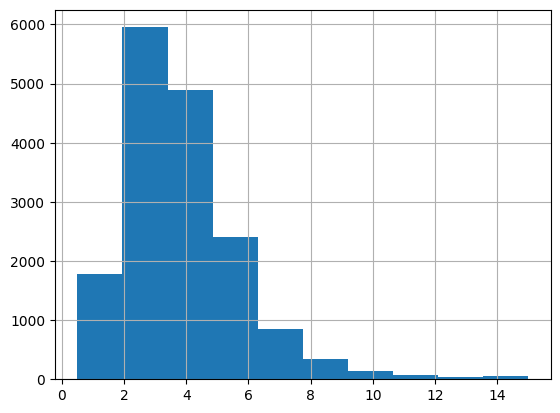

In [ ]:
housing_num['median_income'].hist()

<Axes: >

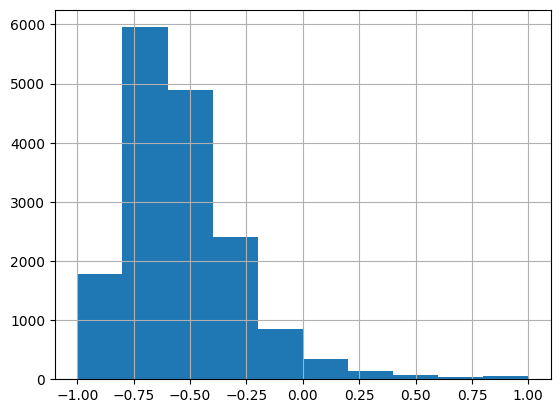

In [ ]:
housing_num_min_max_df = pd.DataFrame(
    housing_num_min_max,
    columns=housing_num.columns
)
housing_num_min_max_df['median_income'].hist()

<Axes: >

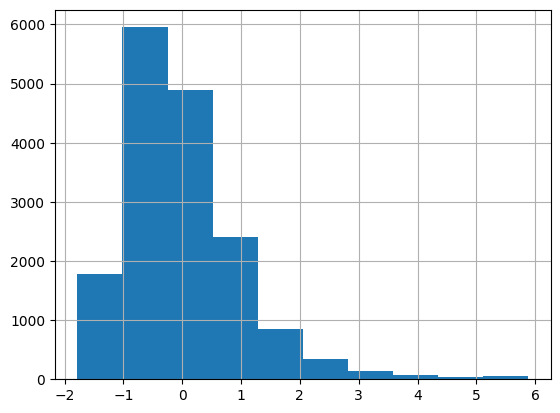

In [ ]:
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)
housing_num_std_scaled_df = pd.DataFrame(
    housing_num_std_scaled,
    columns=housing_num.columns
)
housing_num_std_scaled_df['median_income'].hist()

Sttandardization is better at handling outliers, lets check for outliers in the data.

<Axes: >

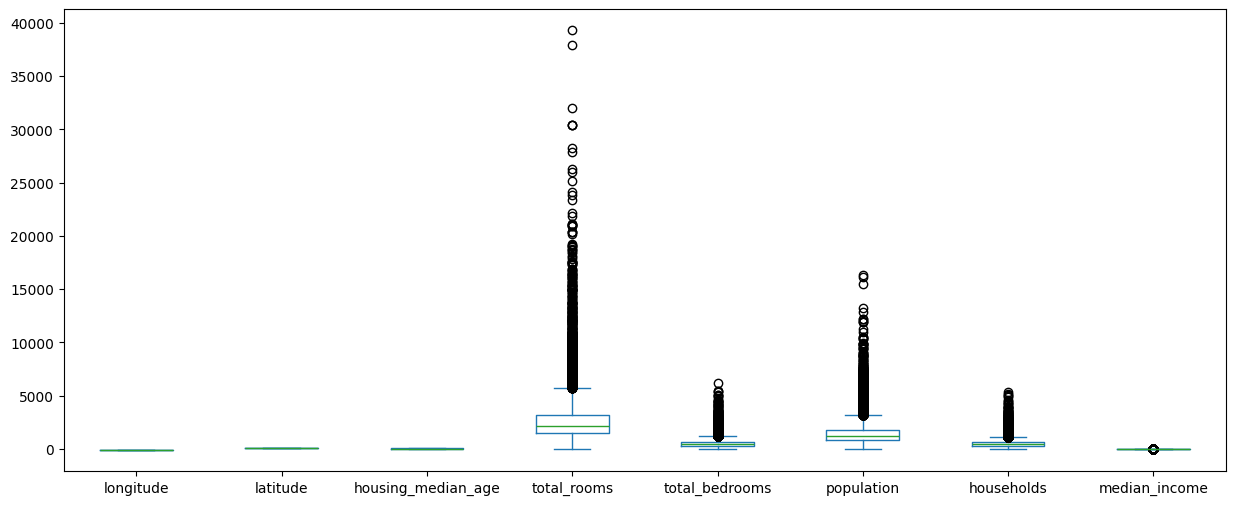

In [ ]:
housing_num.plot(kind='box', figsize=(15, 6))

We observed the presence of outliers in out data, so we will go with Standardization for scaling. But before we scale, we should first transform the data to take care of the skewed features. We also notice features with multimodal distribution. Log transformation works well for right skewed data

In [ ]:
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])
log_tot_rooms = log_transformer.transform(housing[["total_rooms"]])
log_tot_bedrooms = log_transformer.transform(housing[["total_bedrooms"]])
log_households = log_transformer.transform(housing[["households"]])

We will also use a custom transformer that uses a k-means cluster in the fit() method to identify main cluaters in the training data, and then uses rbf_kernel in the transform methood() to measure how similar each sample is to each cluster.

In [ ]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [ ]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]])

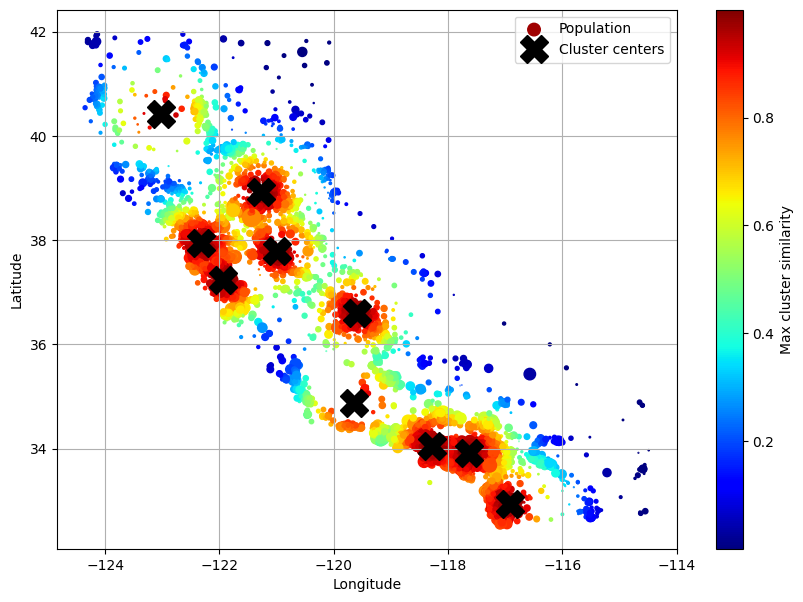

In [ ]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

Above plot shows 10 clusters found by k-means. We can observe that most clusters are located in highly populated and expensive areas.

In [ ]:
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [ ]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [ ]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)

Select and Train a Machine Learning Model

In [ ]:
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7b2...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7b22b03f6330>)])),
                ('linearregression', LinearRegression())])

In [ ]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5]

array([247085.57775975, 397556.65547462, 119417.91338727,  95544.17587666,
       326800.71273627])

In [ ]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

Some of the predictions seem way off. Let's calculate RMSE to check model's performance

In [ ]:
lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

68004.52469464038

This error is very high, indicating that the model is underfitting the training data. The main ways to fix underfitting are
1. Use a more powerful model
2. Feed the training algorithms with better features
3. Reduce the constraints on the model
Since the model is not regularized, it rules out the third option. Let's try a more powerful model

In [ ]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7b2...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7b22b03f6330>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [ ]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

An RMSE of 0 is highly unlikely on unseen data and usually indicates overfitting. We should not evaluate a model’s performance using the same data it was trained on. A DecisionTreeRegressor can memorize the training data and therefore achieve an RMSE of 0 on the training set, which is not useful for assessing the model’s true performance.

In [ ]:
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
pd.Series(tree_rmses).describe()

,0
count,10.000000
mean,66598.582032
std,1898.277140
min,62869.398343
25%,65193.891112
50%,67335.849215
75%,67799.124811
max,68716.769350


Now we can see the validation error, which is high. The model is overfitting since the training error is 0 and the validation error is high. Let's try out anoother model

In [ ]:
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

,0
count,10.000000
mean,46899.732674
std,1069.816294
min,45385.715430
25%,46307.295493
50%,46957.527053
75%,47287.044344
max,49207.702578


In [ ]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = root_mean_squared_error(housing_labels, housing_predictions)
forest_rmse

17515.51493300999

We notice that the validation error is much lower, but the training error is much lower than the validation error, indicating that the model is still overfitting. There are several other models that we can consider here (SVMs, NN), or we can try and fine-tune the current model. Let's search for the best combinations of hyperparameters values

In [ ]:
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b22b00434a0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b22b0041280>},
                   random_state=42, scoring='neg_root_mean_squared_error')

Let's also analyze the relative importance of each feature for making accurate predictions

In [ ]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.05, 0.04, 0.05, 0.01, 0.01, 0.01, 0.01, 0.15, 0.01, 0.01, 0.01,
       0.03, 0.01, 0.  , 0.02, 0.01, 0.01, 0.  , 0.01, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.03, 0.02, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.02, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.  , 0.06,
       0.  , 0.  , 0.  , 0.01, 0.13])

In [ ]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(np.float64(0.1529857299532818), 'log__median_income'),
 (np.float64(0.13067146679776456), 'remainder__income_cat'),
 (np.float64(0.062301909670278086), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.05050575269826582), 'people_per_house__ratio'),
 (np.float64(0.04657868156646083), 'bedrooms__ratio'),
 (np.float64(0.03739647067775269), 'rooms_per_house__ratio'),
 (np.float64(0.0339670799428913), 'geo__Cluster 3 similarity'),
 (np.float64(0.025222926216231015), 'geo__Cluster 17 similarity'),
 (np.float64(0.021091959790250296), 'geo__Cluster 18 similarity'),
 (np.float64(0.018157705967153555), 'geo__Cluster 6 similarity'),
 (np.float64(0.01717215066292458), 'geo__Cluster 22 similarity'),
 (np.float64(0.015538644171977624), 'geo__Cluster 41 similarity'),
 (np.float64(0.015129062360513533), 'geo__Cluster 32 similarity'),
 (np.float64(0.014308537954114003), 'geo__Cluster 35 similarity'),
 (np.float64(0.01370509408139473), 'geo__Cluster 31 similarity'),
 (np.float64(0.013678961868015599), '

Evaluate on the test set

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

42006.63729298367
